# Fine Tuning


We got best result for XGBoost algorithm<br>
So let's try to improve it.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns

from math import sqrt

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function to perform data standardization 
from sklearn.preprocessing import StandardScaler

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Import classes for ML Models
from sklearn.linear_model import Ridge  ## Linear Regression + L2 regularization
from sklearn.svm import SVR ## Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor ## Random Forest Regressor
from sklearn.neighbors import KNeighborsRegressor ## KNN regressor
from sklearn.tree import DecisionTreeRegressor ## Decision Tree Regressor
from sklearn import linear_model ## Lasso Regressor
from sklearn.linear_model import Lasso

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

# To save the final model on disk
from sklearn.externals import joblib
#standard scalar

C:\Users\Hrishikesh\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.shape

(550068, 12)

## Data Preprocessing

In [4]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

### Handling NULL values
we will replace Product_Category_2 NAN values with appropriate mean values according to respective age category <br>
and fill null values in product_category_3 with 0.

In [5]:
col=[df['Product_Category_2'],df['Age']]

In [6]:
def impute_2(col):
    age=col[1]
    product_Category_2=col[0]
    
    if pd.isnull(product_Category_2):
        if age=='0-17':
            return 8
        elif age=='55+':
            return 12
        elif age=='26-35':
            return 9
        elif age=='46-50':
            return 11
        elif age=='51-55':
            return 11
        elif age=='36-45':
            return 10
        else:
            return 8
    else:
        return product_Category_2

In [7]:
#df.Product_Category_2.fillna(0, inplace=True)
df['Product_Category_2']=df[['Product_Category_2','Age']].apply(impute_2,axis=1)

In [8]:
df.Product_Category_3.fillna(0, inplace=True)
#df['Product_Category_3']=df[['Product_Category_3','Age']].apply(impute_2,axis=1)

In [9]:
# Converting Product_Category_2 and Product_Category_3 to int from object, to maintain consistency across the dataframe
df['Product_Category_2'] = df['Product_Category_2'].astype(int)
df['Product_Category_3'] = df['Product_Category_3'].astype(int)

In [10]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

So  we removed all null values

## Modifying features

Now, we need to find new features out of old one to extract key information 

In [11]:
#In Gender, replacing 'F' with 0 and 'M' with 1
df.loc[df['Gender'] == 'F', 'Gender'] = 0
df.loc[df['Gender'] == 'M', 'Gender'] = 1

In [12]:
#In Age column, replacing different ranges with the below values.
def agegroup(x):
    if x=='0-17':
        return 0
    elif x=='18-25':
        return 1
    elif x ==  "26-35" :
        return 2
    elif x ==  "36-45" :
        return 3
    elif x ==  "46-50" :
        return 4
    elif x ==  "51-55" :
        return 5
    elif x ==  "55+" :
        return 6
    
df['AgeGroup']=df['Age'].map(agegroup)

In [13]:
df.drop(['Age'],axis=1,inplace=True)

In [14]:
# In 'Stay_In_Current_City_Years', replacing '4+' with 4
df.loc[df['Stay_In_Current_City_Years'] == '4+', 'Stay_In_Current_City_Years'] = 4

In [15]:
# In 'City_Category',replacing different categories with the values 0, 1, 2 respectively.
df.loc[df['City_Category'] == 'A', 'City_Category'] = 0
df.loc[df['City_Category'] == 'B', 'City_Category'] = 1
df.loc[df['City_Category'] == 'C', 'City_Category'] = 2

In [16]:
# Converting all object type columns to integer to maintain consistency across the dataframe
df['Gender'] = df['Gender'].astype(int)
df['AgeGroup'] = df['AgeGroup'].astype(int)
df['City_Category'] = df['City_Category'].astype(int)
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].astype(int)

In [17]:
# Product_ID preprocess e.g. P00069042 -> 69042
df['Product_ID'] = df['Product_ID'].str.replace('P00', '')
df['Product_ID'] = df['Product_ID'].astype(int)

In [18]:
#df['User_ID'] = df['User_ID'] - 1000000

In [19]:
df.head()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup
0,1000001,69042,0,10,0,2,0,3,8,0,8370,0
1,1000001,248942,0,10,0,2,0,1,6,14,15200,0
2,1000001,87842,0,10,0,2,0,12,8,0,1422,0
3,1000001,85442,0,10,0,2,0,12,14,0,1057,0
4,1000002,285442,1,16,2,4,0,8,12,0,7969,6


In [20]:
# corr indicates the correlation between all the features of the dataset. 
# positive correlation means two qunatities are directly proportinal While negative means inversely proportional.
df.corr()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup
User_ID,1.000000,-0.017619,-0.033474,-0.023971,0.022859,-0.030737,0.020443,0.003825,0.004642,0.003605,0.004716,0.032698
Product_ID,-0.017619,1.000000,0.021084,0.009344,0.010162,-0.003162,0.013194,0.090193,0.023756,-0.144360,-0.103961,0.028892
Gender,-0.033474,0.021084,1.000000,0.117291,-0.004515,0.014660,-0.011603,-0.045594,-0.015350,0.036146,0.060346,-0.004262
Occupation,-0.023971,0.009344,0.117291,1.000000,0.034479,0.030005,0.024280,-0.007618,0.008098,0.012269,0.020833,0.091463
City_Category,0.022859,0.010162,-0.004515,0.034479,1.000000,0.019946,0.039790,-0.014364,0.003770,0.035525,0.061914,0.123079
Stay_In_Current_City_Years,-0.030737,-0.003162,0.014660,0.030005,0.019946,1.000000,-0.012819,-0.004213,-0.001090,0.001977,0.005422,-0.004712
Marital_Status,0.020443,0.013194,-0.011603,0.024280,0.039790,-0.012819,1.000000,0.019888,0.037026,-0.004629,-0.000463,0.311738
Product_Category_1,0.003825,0.090193,-0.045594,-0.007618,-0.014364,-0.004213,0.019888,1.000000,0.355560,-0.385534,-0.343703,0.061197
Product_Category_2,0.004642,0.023756,-0.015350,0.008098,0.003770,-0.001090,0.037026,0.355560,1.000000,-0.291855,-0.164070,0.124851
Product_Category_3,0.003605,-0.144360,0.036146,0.012269,0.035525,0.001977,-0.004629,-0.385534,-0.291855,1.000000,0.288501,-0.007422


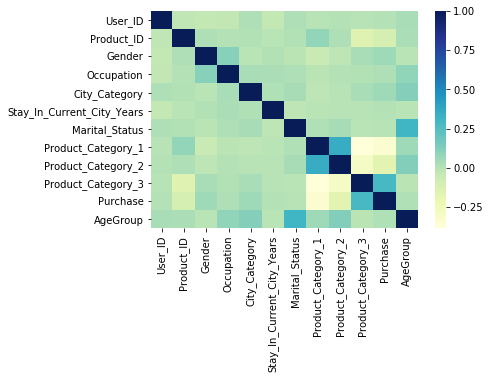

In [21]:
#correlation heatmap
sns.heatmap(data=df.corr(), cmap="YlGnBu")

## Building validation set
Now we need to build validation set to calculete error for different methods.
For this, we will divide training data 80:20.

In [22]:
df.head()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,AgeGroup
0,1000001,69042,0,10,0,2,0,3,8,0,8370,0
1,1000001,248942,0,10,0,2,0,1,6,14,15200,0
2,1000001,87842,0,10,0,2,0,12,8,0,1422,0
3,1000001,85442,0,10,0,2,0,12,14,0,1057,0
4,1000002,285442,1,16,2,4,0,8,12,0,7969,6


In [23]:
# Create separate object for target variable
Y = df['Purchase']
# Create separate object for input features
X = df.drop(['Purchase'], axis=1)

In [24]:
# spliting training data 80:20.
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.2, random_state=123412, shuffle=True)

In [25]:
#standardization
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_validate = sc_X.transform(X_validate)

In [26]:
print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape)

(440054, 11) (110014, 11) (440054,) (110014,)


We tried different algorithms previously. We got top result using XGBoost. So, let's try to improve its hyperparameters.

## Extreme Gradient Boosting

In [27]:
import xgboost

In [28]:
xgb = xgboost.XGBRegressor(n_estimators=140, learning_rate=0.52, gamma=0, subsample=1,colsample_bytree=1, max_depth=7)

In [29]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.52, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=140, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [30]:
vali_predictions = xgb.predict(X_validate)

In [31]:
print("Train Results for XG boost:")
print("Root mean squared error: ", sqrt(mse(vali_predictions, y_validate)))
print("R-squared: ", r2_score(vali_predictions, y_validate))
print("Mean Absolute Error: ", mae(vali_predictions, y_validate))

Train Results for XG boost:
Root mean squared error:  2535.9334986211948
R-squared:  0.656686664664057
Mean Absolute Error:  1879.1083947922468


The <b>best hyperparameters </b> got so far<br>
learning rate: 0.52<br>
max_depth = 7<br>
subsample=1<br>
n_estimators=140

Now, let's check our model is overfitting or not by calculating RMSE for training set.

In [32]:
train_predictions = xgb.predict(X_train)

In [33]:
print("Root mean squared error: ", sqrt(mse(train_predictions, y_train)))
print("R-squared: ", r2_score(train_predictions, y_train))
print("Mean Absolute Error: ", mae(train_predictions, y_train))

Root mean squared error:  2360.932870517949
R-squared:  0.7023118196352419
Mean Absolute Error:  1758.762879949708


As our model predict results with almost same RMSE for both training set and validation set, we can say our model is not overfitted.

## Deploy model to make predictions on test set

In [34]:
Test = pd.read_csv('test.csv')

In [35]:
solution = Test[['User_ID','Product_ID']]

In [36]:
# Product_ID preprocess e.g. P00069042 -> 69042
Test['Product_ID'] = Test['Product_ID'].str.replace('P00', '')

In [37]:
col=[Test['Product_Category_2'],Test['Age']]
Test['Product_Category_2']=Test[['Product_Category_2','Age']].apply(impute_2,axis=1)
Test.Product_Category_3.fillna(0, inplace=True)

In [38]:
# Converting Product_Category_2 and Product_Category_3 to int from object, to maintain consistency across the dataframe
Test['Product_Category_2'] = Test['Product_Category_2'].astype(int)
Test['Product_Category_3'] = Test['Product_Category_3'].astype(int)

In [39]:
#In Gender, replacing 'F' with 0 and 'M' with 1
Test.loc[Test['Gender'] == 'F', 'Gender'] = 0
Test.loc[Test['Gender'] == 'M', 'Gender'] = 1

#In Age column, replacing different ranges with the below values.    
Test['AgeGroup']=Test['Age'].map(agegroup)

Test.drop(['Age'],axis=1,inplace=True)

# In 'Stay_In_Current_City_Years', replacing '4+' with 4
Test.loc[Test['Stay_In_Current_City_Years'] == '4+', 'Stay_In_Current_City_Years'] = 4

# In 'City_Category',replacing different categories with the values 0, 1, 2 respectively.
Test.loc[Test['City_Category'] == 'A', 'City_Category'] = 0
Test.loc[Test['City_Category'] == 'B', 'City_Category'] = 1
Test.loc[Test['City_Category'] == 'C', 'City_Category'] = 2

# Converting all object type columns to integer to maintain consistency across the dataframe
Test['Gender'] = Test['Gender'].astype(int)
Test['AgeGroup'] = Test['AgeGroup'].astype(int)
Test['City_Category'] = Test['City_Category'].astype(int)
Test['Stay_In_Current_City_Years'] = Test['Stay_In_Current_City_Years'].astype(int)
Test['Product_ID'] = Test['Product_ID'].astype(int)

In [40]:
Test.head()

,User_ID,Product_ID,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,AgeGroup
0,1000004,128942,1,7,1,2,1,1,11,0,4
1,1000009,113442,1,17,2,0,0,3,5,0,2
2,1000010,288442,0,1,1,4,1,5,14,0,3
3,1000010,145342,0,1,1,4,1,4,9,0,3
4,1000011,53842,0,1,2,1,0,4,5,12,2


In [41]:
#data standardization
sc_X = StandardScaler()
Test = sc_X.fit_transform(Test)

In [42]:
#making prediction on test data.
test_predictions = xgb.predict(Test)

In [43]:
test_predictions

array([12727.912 , 11090.227 ,  7761.2085, ...,  7900.027 , 18304.398 ,
        1772.6466], dtype=float32)

In [44]:
# adding purchase prediction column to solution
solution['Purchase'] = test_predictions

In [45]:
solution.head()

,User_ID,Product_ID,Purchase
0,1000004,P00128942,12727.912109
1,1000009,P00113442,11090.226562
2,1000010,P00288442,7761.208496
3,1000010,P00145342,3371.144531
4,1000011,P00053842,1880.761597


In [46]:
solution.shape

(233599, 3)

In [47]:
# writing final results to a csv file
solution.to_csv('final_predictions.csv')